In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Preprocessing of the images

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import PIL

## Loading the dataset

In [25]:
train_directory="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [26]:
img_height = img_width = 256
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_directory,
  validation_split=0.2,
  class_names=["NORMAL","PNEUMONIA"],  
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [43]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_directory,
    validation_split=0.2,
   class_names=["NORMAL","PNEUMONIA"],  
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.
Using 124 files for validation.


In [27]:
# function to visualize old and new images 
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

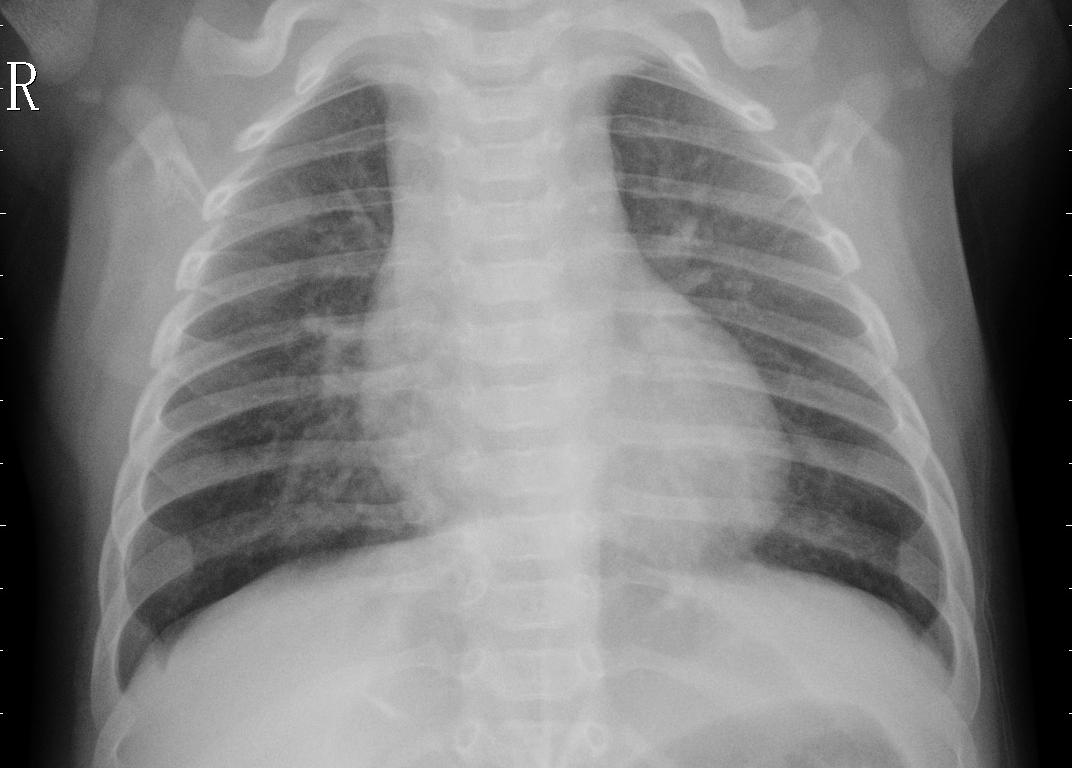

In [28]:
# Read image 
viral_image = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg"
v1 = tf.keras.utils.load_img(viral_image)
PIL.Image.open("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg")
#

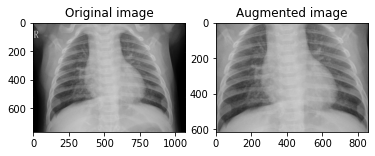

In [29]:
# Trying out central_crop on the above image

cropped = tf.image.central_crop(v1, central_fraction=0.8)
visualize(v1, cropped)

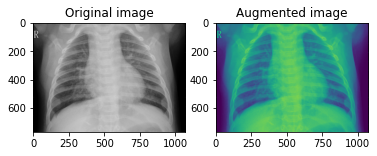

In [30]:
# Trying out conversion from rgb to grayscale 
g1 = tf.image.rgb_to_grayscale(v1)
visualize(v1,g1)

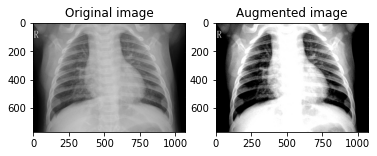

In [31]:
# trying to increase contrast 
k1 = tf.image.adjust_contrast(v1,2.5)
visualize(v1, k1)


In [51]:
# creating preprocessing layers 

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255),
  layers.RandomRotation(0.2),
  layers.RandomFlip(mode="horizontal")
])

In [52]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:

model = Sequential([
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  resize_and_rescale,
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.1),  
  layers.MaxPooling2D(), 
  
  layers.Conv2D(128, 3, padding='same', activation='relu'),
    
  layers.Dropout(0.1),   
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    
  layers.Dropout(0.1),   
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.1),  
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 256)     7168      
_________________________________________________________________
dropout_20 (Dropout)         (None, 256, 256, 256)     0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 128)     295040    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 128)      

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [59]:
epochs=15
history = model.fit(
 train_ds,
  validation_data = test_ds,  
  epochs=epochs,
     callbacks=[callback]
)

Epoch 1/15
131/131 [==============================] - 33s 229ms/step - loss: 0.1472 - accuracy: 0.9422 - val_loss: 0.3868 - val_accuracy: 0.8790
Epoch 2/15
131/131 [==============================] - 31s 230ms/step - loss: 0.1357 - accuracy: 0.9461 - val_loss: 0.3900 - val_accuracy: 0.8871
Epoch 3/15
131/131 [==============================] - 32s 231ms/step - loss: 0.1428 - accuracy: 0.9468 - val_loss: 0.6243 - val_accuracy: 0.8065
Epoch 4/15
131/131 [==============================] - 31s 231ms/step - loss: 0.1255 - accuracy: 0.9514 - val_loss: 0.3925 - val_accuracy: 0.8710
Epoch 5/15
131/131 [==============================] - 31s 229ms/step - loss: 0.1367 - accuracy: 0.9487 - val_loss: 0.6016 - val_accuracy: 0.8306
Epoch 6/15
131/131 [==============================] - 31s 229ms/step - loss: 0.1112 - accuracy: 0.9588 - val_loss: 0.8328 - val_accuracy: 0.7742
Epoch 7/15
131/131 [==============================] - 31s 230ms/step - loss: 0.1137 - accuracy: 0.9545 - val_loss: 0.8286 - val_ac

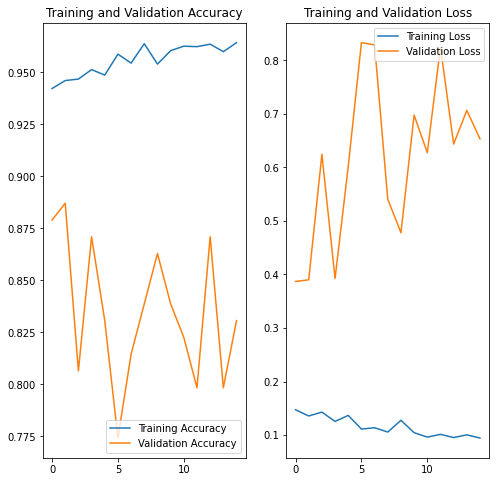

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [93]:
# print(y_pred)
pred_output_y = []

y_pred = model.predict(test_ds)

#print(y_pred)
print(y_pred[0])

print(np.argmax(y_pred[0]))
pred_output_y.append(np.argmax(y_pred[0]))
print(pred_output_y)

print(y_pred[1])

print(np.argmax(y_pred[1]))
pred_output_y.append(np.argmax(y_pred[1]))
print(pred_output_y)
#print(score)



[-5.055571   3.1013489]
1
[1]
[-4.054478   1.5965488]
1
[1, 1]


# confusion matrix 

In [71]:
output

<tf.Tensor: shape=(124, 2), dtype=float32, numpy=
array([[9.04584646e-01, 9.54153538e-02],
       [8.11023347e-06, 9.99991894e-01],
       [1.30212188e-01, 8.69787872e-01],
       [9.82570350e-01, 1.74296275e-02],
       [9.14790630e-01, 8.52094069e-02],
       [6.92282915e-01, 3.07717085e-01],
       [2.14672647e-03, 9.97853220e-01],
       [7.25885911e-06, 9.99992728e-01],
       [2.98891828e-05, 9.99970078e-01],
       [9.55051184e-02, 9.04494941e-01],
       [1.42976381e-02, 9.85702336e-01],
       [3.45295575e-03, 9.96547043e-01],
       [9.21277679e-05, 9.99907851e-01],
       [1.03803456e-03, 9.98961926e-01],
       [1.72272354e-04, 9.99827743e-01],
       [5.87392948e-04, 9.99412656e-01],
       [5.38079679e-01, 4.61920321e-01],
       [1.98650709e-03, 9.98013496e-01],
       [3.04946094e-03, 9.96950507e-01],
       [2.02821731e-03, 9.97971833e-01],
       [9.60712568e-05, 9.99903917e-01],
       [8.44622135e-01, 1.55377880e-01],
       [2.06022337e-03, 9.97939765e-01],
       

In [61]:
from sklearn.metrics import plot_confusion_matrix

In [95]:
y_true = np.concatenate([y for x, y in train_ds], axis=0)
y_true

array([1, 0, 1, ..., 1, 1, 0], dtype=int32)

In [98]:
y_pred_output = [] 
y_pred = model.predict(train_ds)
for i in y_pred:
    y_pred_output.append(np.argmax(i))
    
  

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

In [100]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred_output)

In [101]:
print(cf_matrix)

plot

[[ 325  783]
 [ 902 2163]]


           Normal  Pneumonia
Normal        325        783
Pneumonia     902       2163


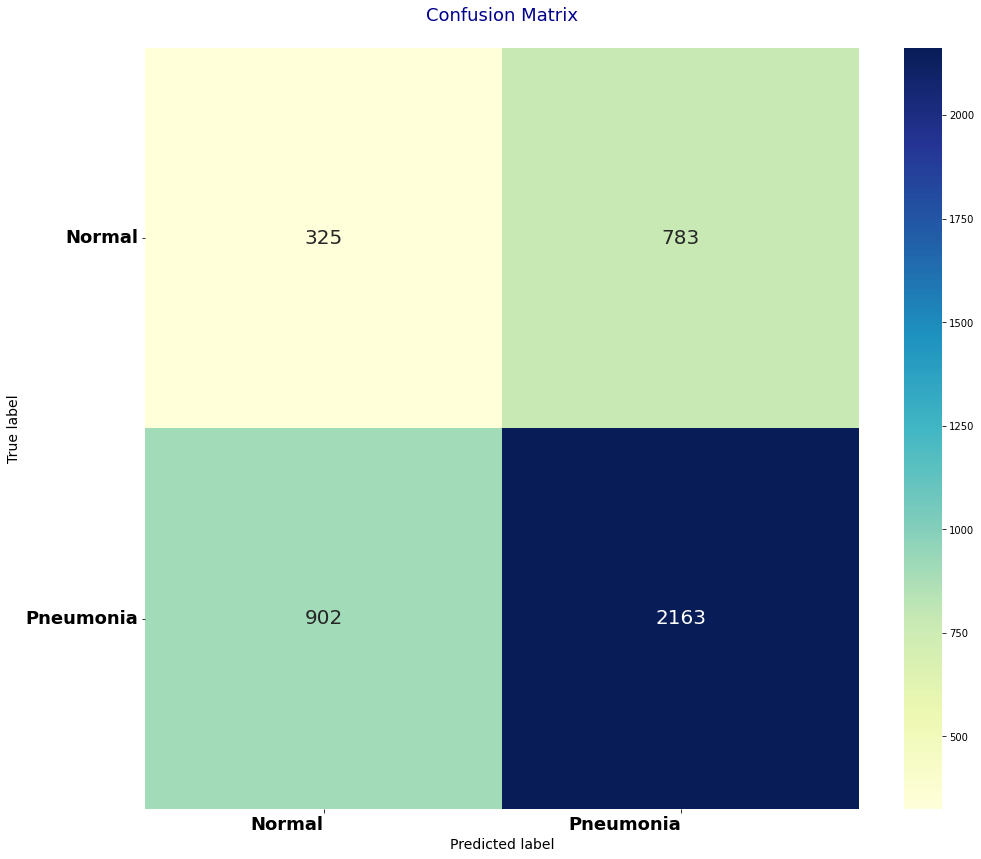

In [103]:
# Data handling
import pandas as pd

# Exploratory Data Analysis & Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix


# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_true, y_pred_output)), 
                      ('Normal', 'Pneumonia'), 
                      ('Normal', 'Pneumonia'))
print(matrix)

# Visualising confusion matrix
plt.figure(figsize = (16,14),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

           Normal  Pneumonia
Normal         11         33
Pneumonia      16         64


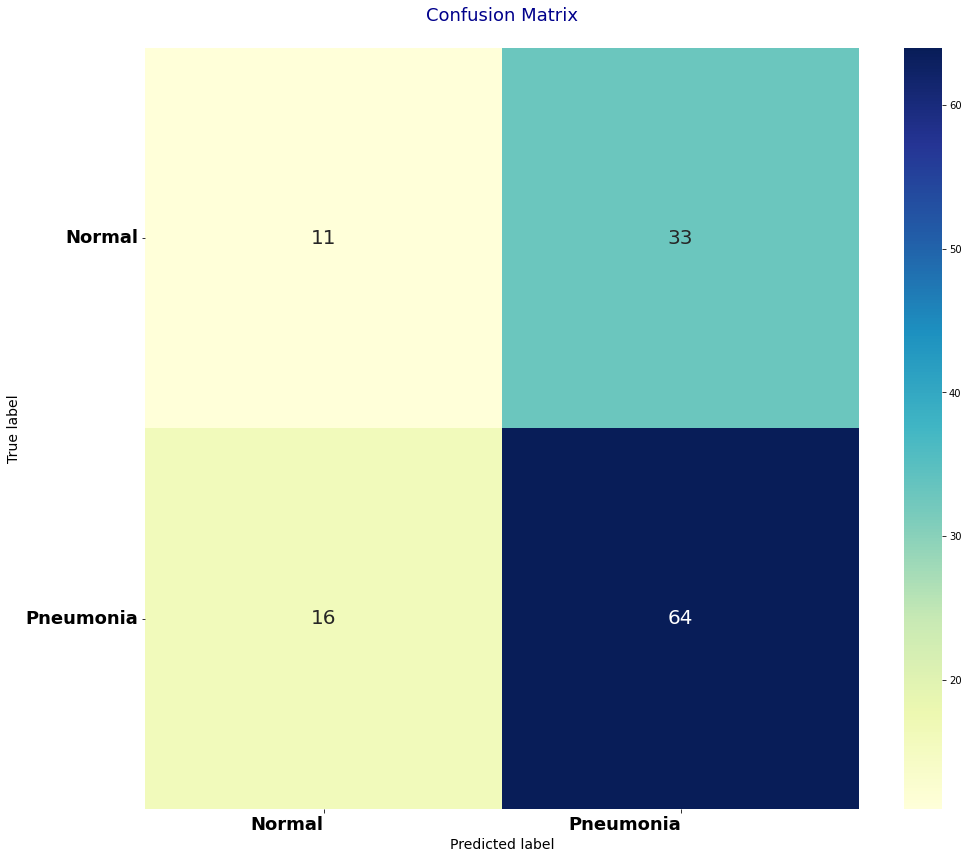

In [108]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
#y_predicted_test = model.predict(test_ds)
y_pred_output = [] 
y_pred = model.predict(test_ds)
for i in y_pred:
    y_pred_output.append(np.argmax(i))
    
# Plotting confusion matrix
matrix = pd.DataFrame((metrics.confusion_matrix(y_true, y_pred_output)), 
                      ('Normal', 'Pneumonia'), 
                      ('Normal', 'Pneumonia'))
print(matrix)

# Visualising confusion matrix
plt.figure(figsize = (16,14),facecolor='white')
heatmap = sns.heatmap(matrix, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 18, weight='bold')

plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()
    
    




# Saving the trained model

In [109]:
model.save("Save_model.h5")